In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

## 데이터 준비

In [2]:
# -------------------------------------------------
# data 불러오기
# -------------------------------------------------
df = pd.read_csv('C:/Users/EL087/Desktop/MS_MachineLearning/data/bike_sharing_demand.csv', parse_dates=['datetime'])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# 전처리

### 파생컬럼 추가

In [3]:
# --------------------------------------------
# 연, 월, 시, 요일
# --------------------------------------------
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek # 월요일:0, 일요일:6
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,4,5


### 변수 선택

In [4]:
# --------------------------------------------
# 독립변수, 종속변수선택
# --------------------------------------------

# 독립변수에 사용하지 않을 컬럼
del_cols = ['datetime','casual','registered','count','temp'] 

X = df.drop(del_cols, axis=1).copy()
y = df['count']

X.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,dayofweek
0,1,0,0,1,14.395,81,0.0,2011,1,0,5
1,1,0,0,1,13.635,80,0.0,2011,1,1,5
2,1,0,0,1,13.635,80,0.0,2011,1,2,5
3,1,0,0,1,14.395,75,0.0,2011,1,3,5
4,1,0,0,1,14.395,75,0.0,2011,1,4,5


In [5]:
# ------------------------------------------------
# 독립변수 - 범주형, 수치형, 순환형 변수 구분
# ------------------------------------------------
cat_cols = ['season','holiday','workingday','weather']      
num_cols = ['atemp','humidity','windspeed', 'year']
cycle_cols = ['month', 'hour', 'dayofweek']

#### 순환형 데이터 인코딩

순환형(주기적인) 데이터를 사인($\text{sin}$) 및 코사인($\text{cos}$) 함수를 이용해 인코딩하는 이유
- 모델이 시간의 연속성과 주기성을 올바르게 인식하도록 돕기 위해서

**1. 순환성(주기성) 문제 해결**

시간, 월, 요일과 같은 데이터는 다음과 같은 순환성을 가짐
- 23시 다음은 0시 (24시간 주기) / 12월 다음은 1월 (12개월 주기) / 일요일(6) 다음은 월요일(0) (7일 주기)

만약 이 데이터를 그대로 숫자 값($0, 1, 2, \dots$)으로 모델에 입력하면,  
모델은 $23$과 $0$ 사이의 거리가 $23$이라고 잘못 인식 (실제 거리는 $1$)

- 잘못된 해석 (선형성): 모델은 **$23 \to 0$**의 변화를 급격한 하락으로 해석하여 $23$과 $0$을 멀리 떨어진 별개의 값으로 간주
- 올바른 해석 (순환성): 실제로는 $23$과 $0$이 가장 가까운 값이어야 함

**2. 사인-코사인 인코딩의 역할**

$\text{sin}$과 $\text{cos}$ 함수는 이러한 순환성을 2차원 좌표계에 매핑하여 해결
- 공식 원리: $\text{sin}$과 $\text{cos}$ 값은 주기적으로 $0$부터 $1$ 또는 $-1$까지 변화하며,  
이 두 값을 $(x, y)$ 좌표로 사용하면 데이터가 단위 원(Unit Circle) 위에 놓이게 됨
$$\text{각도} = 2 \pi \times \frac{\text{현재 값}}{\text{주기}}$$
- $\text{X} = \text{cos}(\text{각도})$, $\text{Y} = \text{sin}(\text{각도})$

- 예시 (시간 $\text{hour}$): $23$시와 $0$시를 인코딩하면:
    - $23$시는 원 위의 한 점에 위치
    - $0$시는 원 위의 다른 점에 위치하는데, 이 두 점 사이의 유클리드 거리가 가장 짧게 계산됨

**3. 결론**

$\text{sin}$과 $\text{cos}$ 두 변수를 동시에 사용하면, 모델은 $0$시와 $23$시가 가까움을 인식하여,  
시간이 순환한다는 사실을 학습할 수 있게 되므로, 예측 성능이 향상됨  
즉, 시간의 선형적 연속성을 파괴하고 주기적인 연속성을 부여하는 것이 인코딩의 핵심 목표

In [6]:
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)

X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)

X['dayofweek_sin'] = np.sin(2 * np.pi * X['dayofweek'] / 7)
X['dayofweek_cos'] = np.cos(2 * np.pi * X['dayofweek'] / 7)

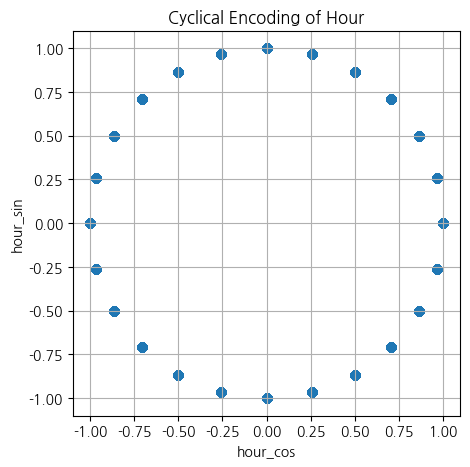

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(X['hour_cos'], X['hour_sin'])
plt.title('Cyclical Encoding of Hour')
plt.xlabel('hour_cos')
plt.ylabel('hour_sin')
plt.grid(True)
plt.show()

- 순환형 데이터 인코딩은 데이터 누수가 발생하지 않음
- 그러므로 훈련/데이터 세트 분할 전, 후 어디에 하여도 상관 없음

### 훈련세트 테스트세트 분할

In [8]:
# -------------------------
# 훈련세트/테스트세트 분할
# -------------------------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8164, 17) (2722, 17) (8164,) (2722,)


### 수치형 변수 스케일링

In [ ]:
# -------------------------
#   스케일링
# -------------------------
from sklearn.preprocessing import StandardScaler    # 표준화 스케일링
scaler = StandardScaler()

train_scaled = scaler.fit_transform(X_train[num_cols])
test_scaled = scaler.transform(X_test[num_cols])

# -------------------------
#   데이터프레임으로 변환
# -------------------------
X_train_scaled = pd.DataFrame(train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(test_scaled, columns=num_cols, index=X_test.index)

### 범주형 변수 원핫인코딩

- 원래의 범주 개수만큼의 **새로운 이진(Binary) 특성(컬럼)**을 생성
    - 변환 원리: 하나의 범주를 나타내는 특성에는 1을, 나머지 특성에는 모두 0을 부여
- 기계 학습 모델이 범주형 데이터를 올바르게 처리하고 해석할 수 있도록 변환하기 위함
- 대부분의 기계 학습 알고리즘은 숫자(수치) 형태의 입력만 처리할 수 있음
- 순서(서열) 정보를 부여하는 것을 방지하기 위함 (레이블 인코딩은 잘못된 순서나 크기 관계를 학습)

In [10]:
from sklearn.preprocessing import OneHotEncoder

# -------------------------
#   원핫인코딩
# -------------------------
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

train_encoded = encoder.fit_transform(X_train[cat_cols])
test_encoded = encoder.transform(X_test[cat_cols])

# -------------------------
#   생성된 열 이름
# -------------------------
ohe_columns = encoder.get_feature_names_out(cat_cols)

# -------------------------
#   DataFrame으로 변환
# -------------------------
X_train_encoded = pd.DataFrame(train_encoded, 
             columns = ohe_columns,
             index=X_train.index)

X_test_encoded = pd.DataFrame(test_encoded, 
             columns = ohe_columns,
             index=X_test.index)

| 옵션 | 설정 값 | 의미 |
| :---: | :---: | :--- |
| $\text{handle\_unknown}$ | $\text{'ignore'}$ | 훈련 데이터에는 없었지만 테스트 데이터에 나타나는 새로운(알 수 없는) 범주를 만났을 때 무시하고 인코딩하는 방식. 새로운 범주에 해당하는 모든 출력의 열을 **$0$**으로 설정.  ($\text{'error'}$로 설정하면 오류를 발생시킵니다.) |
| $\text{sparse\_output}$ | $\text{False}$ | 인코딩 결과를 **밀집 행렬(Dense Array)**로 반환하도록 지정 (기본값은 $\text{True}$이며, 메모리 효율적인 **희소 행렬(Sparse Matrix)**로 반환) |

1. $\text{encoder.get\_feature\_names\_out(cat\_cols)}$ 역할
- $\text{encoder}$: 이전에 정의하고 범주형 데이터로 **훈련(fit)**시킨 $\text{OneHotEncoder}$ 객체
- $\text{get\_feature\_names\_out()}$: $\text{scikit-learn}$ 변환기(Transformer) 객체에 내장된 메서드로, 변환 후에 생성된 출력 특성들의 이름을 배열 형태로 반환
- $\text{cat\_cols}$: 이 $\text{OneHotEncoder}$를 훈련시킬 때 사용했던 원래의 범주형 컬럼 이름들의 리스트를 인수로 전달

2. 코드 실행 결과
- 코딩된 컬럼 이름들의 $\text{NumPy}$ 배열이 ohe_columns 변수에 저장
- ex) $$\text{ohe\_columns} = [\text{'weather\_1'}, \text{'weather\_2'}, \text{'weather\_3'}, \text{'season\_spring'}, \text{'season\_summer'}]$$

### 훈련에 사용할 최종 데이터 만들기

In [11]:
cycle_cols = ['hour_sin','hour_cos', 'month_sin', 'month_cos', 'dayofweek_sin', 'dayofweek_cos']
X_train_cycled = X_train[cycle_cols]
X_test_cycled = X_test[cycle_cols]

In [12]:
X_train_preprocessed = pd.concat([X_train_cycled, X_train_scaled, X_train_encoded], axis=1)
X_test_preprocessed = pd.concat([X_test_cycled, X_test_scaled, X_test_encoded], axis=1)

- 전처리를 하기 전에 훈련 데이터와 테스트 데이터를 먼저 분리하는 이유: **데이터 누수 방지**

**1. 데이터 누수(Data Leakage)란?**

데이터 누수는 모델이 훈련 과정에서 테스트 세트에 대한 정보(통계적 특성)를 미리 얻게 되는 현상  
    이는 테스트 세트가 모델에게 '보지 못한' 데이터의 역할을 제대로 하지 못하게 만들어, 모델의 성능을 비현실적으로 높게 평가하게 만듦

**2. 스케일링에서의 데이터 누수 📏**

수치형 변수를 스케일링(예: $\text{StandardScaler}$나 $\text{MinMaxScaler}$)할 때, 데이터의 평균과 표준편차 또는 최솟값과 최댓값을 사용

- 잘못된 순서 (스케일링 $\to$ 분리): 전체 데이터($\text{Train} + \text{Test}$)의 최댓값과 최솟값을 사용하여 스케일링을 하면,  
 **훈련 데이터가 테스트 데이터의 극단적인 값(아웃라이어)**에 대한 정보를 미리 학습하게 됨

- 올바른 순서 (분리 $\to$ 스케일링):

    1. 훈련 데이터의 통계량(평균, 표준편차 등)만으로 스케일링 기준을 **학습($\text{fit}$)**
    2. 이 기준을 훈련 데이터에 **적용($\text{transform}$)**
    3. 이 동일한 기준을 테스트 데이터에 그대로 **적용($\text{transform}$만!)**

**3. 범주형 인코딩에서의 데이터 누수 🏷️**

원-핫 인코딩에서는 $\text{handle\_unknown='ignore'}$ 옵션을 사용하여 훈련 시 보지 못한 범주를 처리

- 잘못된 순서: 전체 데이터로 인코딩을 하면, 훈련 데이터가 테스트 데이터에만 존재하는 특이한 범주의 존재 여부를 미리 알게 됨  
    이는 모델이 현실에서 접할 수 있는 새로운 상황에 대한 대처 능력을 과대평가하게 만듦

- 올바른 순서: 훈련 데이터의 범주만으로 인코더를 학습($\text{fit}$)시키고,  
    테스트 데이터에는 훈련 데이터에서 정의된 범주만을 기반으로 인코딩을 적용($\text{transform}$)

# LinearRegression

In [13]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_preprocessed, y_train)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model.predict(X_test_preprocessed)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')

# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(X_train_preprocessed, y_train))
print('test>>>>>>>>>>>>>', model.score(X_test_preprocessed, y_test))

r2:0.5056727637202971
rmse:127.36119405709948
mae:92.56940620538275
mse:16220.873751650151
train>>>>>>>>>>>> 0.5131849258621071
test>>>>>>>>>>>>> 0.5056727637202971


- 과적합 여부 판단: 두 값의 차이는 약 0.0075로 매우 작으므로, 과적합 되지 않고 일반화 성능을 잘 유지

- 성능 수준 진단: 두 R^2 값이 0.5 수준으로 비슷하게 낮게 나오니 과소적합에 가까움

- 조치 방향
    - 모델 복잡도 증가: 더 복잡한 모델(예: 더 깊은 신경망, 트리 개수를 늘린 앙상블 모델 등)을 사용
    - 특성 공학(Feature Engineering): 예측에 도움이 될 새로운 특성을 생성  
         (예: 비선형 관계를 반영하기 위해 온도의 제곱 항을 추가하거나, 상호작용 항을 만듦)
    - 하이퍼파라미터 튜닝: 모델의 성능을 향상시키는 방향으로 하이퍼파라미터를 조정

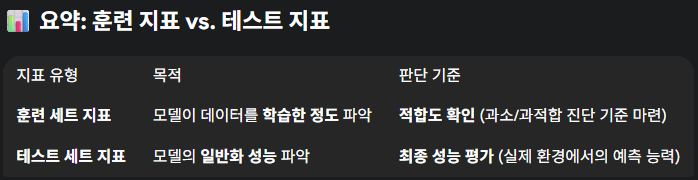

# DecisionTreeRegressor

In [14]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_preprocessed, y_train)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model.predict(X_test_preprocessed)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')


# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(X_train_preprocessed, y_train))
print('test>>>>>>>>>>>>>', model.score(X_test_preprocessed, y_test))

r2:0.8996341877199002
rmse:57.38821994443536
mae:34.6208670095518
mse:3293.407788390889
train>>>>>>>>>>>> 0.9999967687295567
test>>>>>>>>>>>>> 0.8996341877199002


- 과적합 여부 판단: 훈련 성능이 거의 완벽하고, 두 값의 차이는 약 10으로 큰 차이를 보이며 일반화 능력이 떨어졌으므로 과적합

- 조치 방향
    - 모델 복잡도 감소: 사용하고 있는 모델이 너무 복잡하다면(예: 너무 깊거나 넓은 신경망, 과도하게 높은 차수의 다항 회귀), 모델의 크기나 유연성을 줄임
    - 규제(Regularization) 적용: L1 (Lasso) 또는 L2 (Ridge) 규제를 적용하여 모델의 가중치(Weights)가 너무 커지는 것을 방지하고 복잡도를 제어
    - 데이터 증강: 훈련 데이터의 양을 늘리거나(가능하다면), 데이터 증강을 통해 훈련 데이터가 더 다양한 패턴을 갖도록 만듦

# RandomForestRegressor

In [15]:
# --------------------------------------------
# 모델 생성 및 훈련
# --------------------------------------------
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train_preprocessed, y_train)

# --------------------------------------------
# 예측
# --------------------------------------------
y_pred = model.predict(X_test_preprocessed)

# --------------------------------------------
# 모델 성능 평가
# --------------------------------------------
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_squared_error
r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'r2:{r2}')
print(f'rmse:{rmse}')
print(f'mae:{mae}')
print(f'mse:{mse}')


# --------------------------------------------
# 과적합 확인
# --------------------------------------------
print('train>>>>>>>>>>>>', model.score(X_train_preprocessed, y_train))
print('test>>>>>>>>>>>>>', model.score(X_test_preprocessed, y_test))

r2:0.9528438894134199
rmse:39.336783085841866
mae:24.57365295126133
mse:1547.3825035425748
train>>>>>>>>>>>> 0.9922324356774103
test>>>>>>>>>>>>> 0.9528438894134199


- 과적합 여부 판단: 훈련 성능이 거의 완벽하고, 두 값의 차이는 약 4의 차이를 보이며 일반화 능력이 떨어졌으므로 과적합

- 성능 수준 고려

    두 값 모두 0.95 이상으로 절대적인 성능 수준이 매우 높으므로 과적합 경향이 있어 미세 조정이 필요

- 조치 방향
    - 규제(Regularization): $\text{Ridge}$나 $\text{Lasso}$와 같은 규제를 적용하여  
     훈련 성능을 약간 희생하더라도 모델의 복잡도를 낮추고 테스트 성능을 유지하거나 미세하게 올릴 수 있는지 확인
    - 데이터 추가: 가능한 경우, 더 많은 훈련 데이터를 확보하여 모델이 더 다양한 패턴을 학습